#Lossy compression of images

In [1]:
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import random


In [20]:
if not os.path.exists('lfwcrop_grey'):
    !wget http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip
    !unzip 'lfwcrop_grey.zip'

filenames = []
images = []
counter=0
for filename in os.listdir('lfwcrop_grey/faces'):
    filenames.append(filename)
    image = np.array(Image.open(os.path.join('lfwcrop_grey/faces', filename)))
    images.append(image)
    counter=counter+1
    if counter==2000:
      break

images = np.array(images)

X = images.reshape(2000, 64*64)


Printings some images

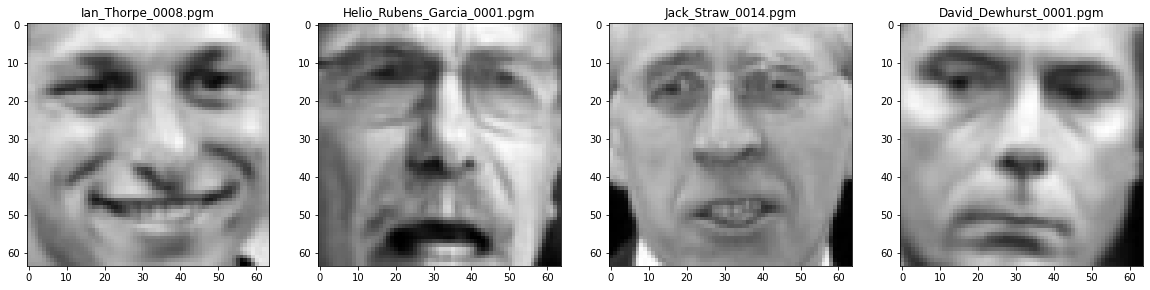

In [3]:
plt.figure(figsize=(20, 10))
num_images = 4
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    index = np.random.choice(range(len(images)))
    image = images[index]
    filename=filenames[index]
    plt.imshow(image, 'gray')
    plt.title(filename)

Calculating the covariance matrix,finding eigen values and eigen vectors and sort them

In [4]:
cov_matrix=np.cov(X.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)


In [5]:
eigen_pair = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
eigen_pair.sort(key=lambda x: x[0], reverse=True)

Calculating what number of dimensions that will leave us with variance of 99%

In [6]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1


In [16]:
print(d)

456


Calculating the projection matrix , the role the projection matrix is to project the 4096 pixels image onto lower dimension.
The projection matrix is made of colums of eigen vectors

In [ ]:
projection_matrix = np.empty(shape=(X.shape[1], d))

for index in range(d):
    eigenvector = eigen_pair[index][1]
    projection_matrix[:, index] = eigenvector


A theorm in linear algebra claims that the eigen vectors are a basis of a vector space. each reshaped eigen vector is a eigen face, a.k.a template as you can see below. linear combination of them can restore images from the dataset.

*face=k_1 * template_1+....+ k_d *template_d

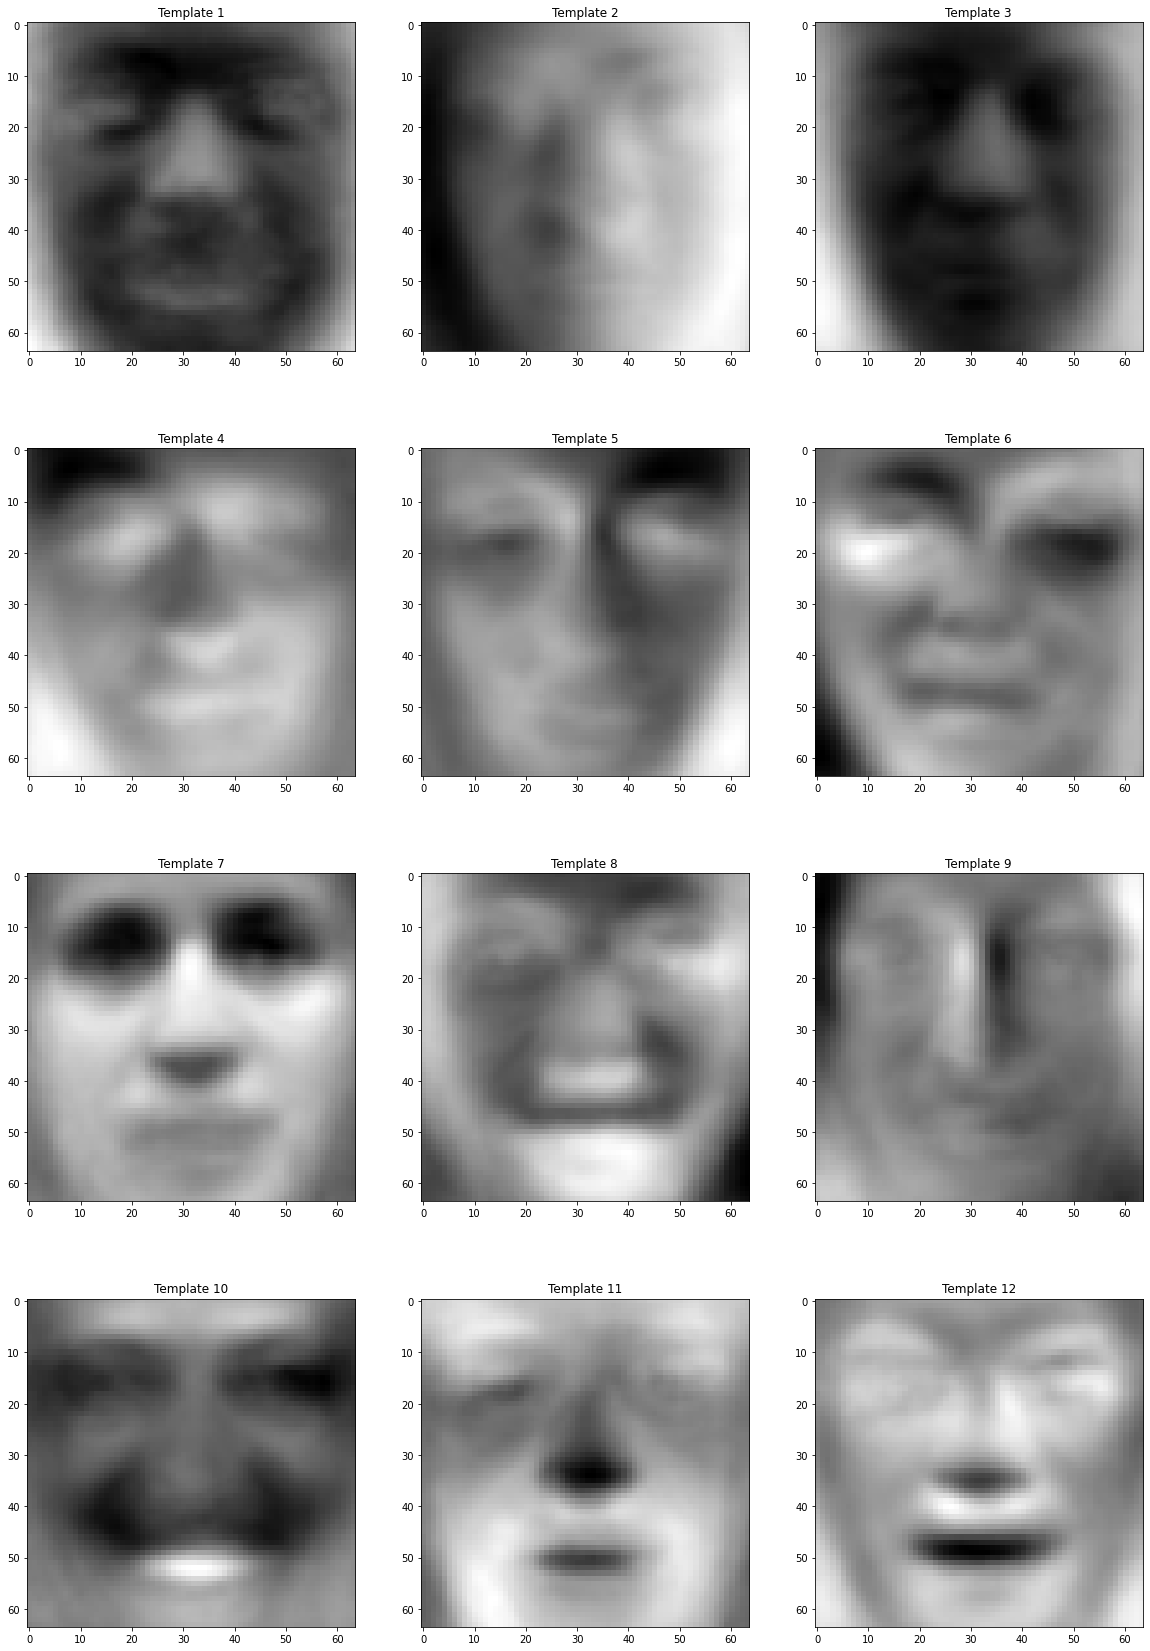

In [15]:
basis = projection_matrix.reshape(64, 64, d)

plt.figure(figsize=(20, 30))

for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(basis[:,:,i], 'gray')
    plt.title('Template {}'.format(i+1))

Finding the values k_1,... ,k_d

In [18]:

from scipy.sparse.sputils import matrix
# Matrix multiply X(2000, 4096) with projection_matrix(4096, 577)
projected_data = X.dot(projection_matrix)  # (2000, 577)



[[-6.35721641e+03 -1.99933461e+02  8.20284953e+02 ... -6.06501135e+00
  -2.53691870e+01 -2.64237271e+00]
 [-1.02269955e+04  1.92799657e+03 -2.08974897e+02 ... -8.85423741e-01
   1.31758576e+01  1.22563403e+00]
 [-8.51383140e+03  1.18493792e+03  2.17472859e+03 ... -2.85156958e+01
  -2.26550776e+00  1.12244348e+01]
 ...
 [-6.42899991e+03  6.21669014e+02 -6.68816663e+02 ...  7.09452260e+00
   1.45773345e+01 -1.48623204e+01]
 [-6.46831450e+03  2.06468075e+03  2.15388590e+03 ... -8.99391643e+00
   1.97270488e+01 -2.99946989e+01]
 [-6.21407020e+03  4.70521716e+02  3.09283598e+02 ...  1.70216511e+01
  -1.15506411e+01  1.08017563e+01]]


Decompress the data

Label George_Lopez_0002.pgm


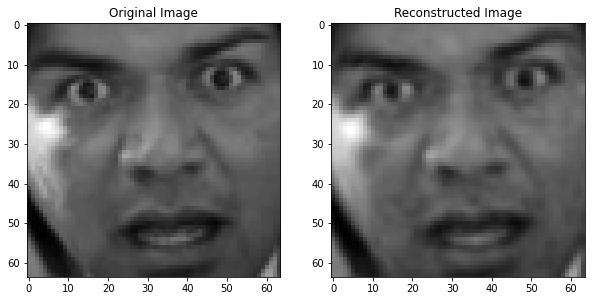

In [11]:

index = random.randint(0,2000)

projected_image= np.expand_dims(projected_data[index], 0)  # (1, num_dims)

# Matrix multiply projected_image(1, num_dims) with projection_matrix transposed(num_dims, 784)
reconstructed_image = projected_image.dot(projection_matrix.T)  # (1, 784)
reconstructed_image = reconstructed_image.reshape(64, 64)

print('Label {}'.format(filenames[index]))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(images[index], 'gray')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, 'gray')


The loss function

In [12]:

loss_val=0
for i in range(2000):
  index=i
  reconstructed_image = projected_image.dot(projection_matrix.T)  # (1, 784)
  projected_image= np.expand_dims(projected_data[index], 0)  # (1, num_dims)
  reconstructed_image = reconstructed_image.reshape(64, 64)

  loss = (1/(64*64))*(np.abs(np.sum(np.subtract(reconstructed_image, images[index]))))
  loss_val=counter+loss

print(loss_val/2000)

1.0039553937565866
